# Laplace Approximation: the world from the peak of the mountain

The Laplace method is a powerful technique to approximate the shape of a given function through a Gaussian.
The approximation relies on the Taylor expansion of the (log-)function of interest $f$ that we wish to approximate.
Starting from the simple observation that:

$$ f(\theta) = \exp(\log(f(\theta)) = \exp(g(\theta)),$$

Let us assume that $g$, and thus $f$, have a maximum in $\theta_0$. For any other point $\theta$ sufficiently close to the maximum, we can now approximate the function from this priviledged point of view, to obtain:

$$g(\theta) = g(\theta_0) + g'(\theta_0)(\theta - \theta_0) + \frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2 + O((\theta - \theta_0)^3),$$

In particular, since $\theta_0$ is the maximum, we obtain:

$$g(\theta) \approx g(\theta_0) + \frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2.$$

Taking the exponential on both sides we have:

$$ f(\theta) = \exp(g(x)) \approx \exp(g(\theta_0))\exp(\frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2). $$

In this last equation we can recognize the typical term of the Gaussian pdf:

$$\exp(\frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2),$$

which reminds us of a Gaussian distribution with mean $\theta_0$, and variance $-\frac{1}{g''(\theta_0)}$. This is telling us that our function can be actually approximated (up to a normalizaing constant) by a Gaussian distribution centered around the maximum, and with variance equal to the inverse of the second derivative (the Hessian).

In practice, when we need to approximate a posterior pdf $f$ that we cannot compute in close form, we may simply find its maximum $\theta_0$, and the Hessian $g''(\theta_0)$, and replace them in the corrisponding Gaussian form.
When evaluating $f$ we therefore obtain:


$$\int_a^b f(\theta) d\theta \approx \exp(g(\theta_0)) \int_a^b \exp(-\frac{1}{2}\frac{(\theta - \theta_0)^2}{-g''(\theta_0)^{-1}}) d\theta$$.

If we call $\Phi(\theta|\theta_0,-\frac{1}{g''(\theta_0)})$, the Gaussian pdf, we finally obtain: 

$$\int_a^b f(\theta) d\theta \approx \exp(g(\theta_0))\sqrt{\frac{2\pi}{-g''(\theta_0)}}\int_a^b \Phi(\theta|\theta_0,-\frac{1}{g''(\theta_0)}) d\theta = \exp(g(\theta_0))\sqrt{\frac{2\pi}{-g''(\theta_0)}} \left(\Phi(a|\theta_0,-\frac{1}{g''(\theta_0)}) -  \Phi(b|\theta_0,-\frac{1}{g''(\theta_0)})\right)$$

It is worth noticing that the Laplace approximation replaces the problem of integrating a function with the problem of maximizing it. In order to compute the Laplace approximation, we have to compute the location of the mode, which is an optimization problem. Often, this problem is faster to solve using function optimizers than integrating the same function would be.



**Example. The Laplace approximation of a Binomial distribution**
We can derive the Laplace approximation for the Binomial distribution by simply applying the steps introduced previously.
The Binomial distribution is:
$$f(\theta|y,N)\approx\theta^y(1-\theta)^{N-y},$$

for which the logarithm follows:

$$\log(f) = y\log(\theta) + (N-y)\log(1-\theta).$$

To compute our approximation, we need to:
- Compute the maximum of the log-distribution. We can do this analytically: we derive with respect to \theta and we solve:
$$\frac{d\log(f)}{d\theta} = \frac{y}{\theta} - \frac{N-y}{1-\theta} = 0 \Longrightarrow \frac{(1-\theta)y - \theta(N-y)}{\theta(1-\theta)} = 0$$.
$$y-\theta y - N\theta + \theta y =0 \Longrightarrow y - N\theta = 0 \Longrightarrow \theta = \frac{y}{N}$$

- Compute the second derivative of the log-distribution with respect to $\theta$:
$$\frac{d^2\log(f)}{d\theta^2} = -\frac{y}{\theta^2} - \frac{N-y}{(1-\theta)^2} $$

At this point the problem is solved: the approximation will be a Gaussian with mean $\mu = \frac{y}{N}$ and variance $\sigma^2 = -(-\frac{N^2}{y} - \frac{N-y}{(1-\frac{y}{N})^2})^{-1}$.

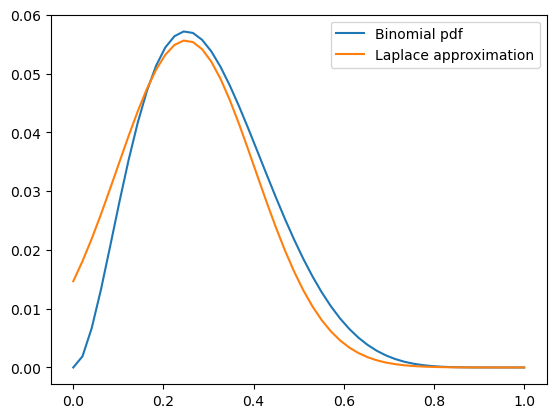

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Example: Laplace approximation of the Binomial distribution

y = 2
# y = 
N = 8
# N = 4

theta = np.linspace(0,1)

f = theta**y*(1-theta)**(N-y)

plt.plot(theta,f/np.sum(f), label = 'Binomial pdf')

fmax = y/N

Hessian = -y/fmax**2 - (N-y)/(1-fmax)**2

var = -1/Hessian

Laplace_approx = norm(fmax, np.sqrt(var))

plt.plot(theta, Laplace_approx.pdf(theta)/np.sum(Laplace_approx.pdf(theta)), label = 'Laplace approximation')
plt.legend()

**Exercise.** From the previous exercise, compute the Laplace approximation resulting from incliding a prior $Beta(2,3)$.

In the following applications, the optimization will be performed by using standard optimizers available in *scipy*

In [2]:
import scipy.optimize as optimize
from scipy.optimize import minimize
from scipy.optimize import Bounds

y = 4
N = 8

bounds = Bounds(0, 1)
fun = lambda x: -(y*np.log(x)+ (N-y)*np.log(1-x))
res = optimize.minimize(fun, (0.005), bounds = bounds, method='trust-constr')
print('The maximum of the Binomial is: ', res.x)






The maximum of the Binomial is:  [0.49999999]


# Bayesian modeling in action

In what follows we are going to explore the practical use of Bayesian modeling. 
We will first keep the technical aspects of the inference process hidden, by focusing on model interpretation, sampling, and simulation. The maths behind approximated inference will be only sketched, and detailed in a second moment. 



In [3]:
import pandas as pd
import sys

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

%run tools.py

The dataset *Howell* contains partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.

In [4]:
data = pd.read_csv('Howell1.csv', sep = ';')
print(data[:10])

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0
5  163.830  62.992589  35.0     1
6  149.225  38.243476  32.0     0
7  168.910  55.479971  27.0     1
8  147.955  34.869885  19.0     0
9  165.100  54.487739  54.0     1


Which kind of relationship between height and weight do you think we could expect? We want find a Bayesian answer to this question.
We can start our investigation by considering only adult individuals.

In [5]:
data1 = data[data.age>=18]

We start by fitting a model for height only. Following what seen in the previous lesson we can reasonably assume that height is Gaussian distributed, as at the end it is the result of infinitesimal accumulations of growth during the life span. 
Therefore, for each subject $i$, we assumen that his/her height is distributed as :

$$\mbox{height}_i\sim N(\mu,\sigma^2).$$

In particular, due to exchangeability, we also have 

$$p(\mbox{height}) = p(\mbox{height}_1, \mbox{height}_2, \ldots, \mbox{height}_N) = p(\mbox{height}_1)p(\mbox{height}_2)\cdots p(\mbox{height}_N),$$

which turns out to be a product of Gaussian likelihoods, as seen in the previous lesson.


Once agreed on the use of a Gaussian likelihood, we need to specify a prior. What could be a proper choice for the mean height? Of course, we can use a Gaussian model encoding our belief on average height in the population, and its variance. For example, by making this assumption:

$$ p(\mu) = N(178, 400),$$

we say that the average height is of $178cm$, with a variability of $\pm 2\sigma = [138cm, 218cm]$, which is a quite generous interval where to expect the mean to fall. For the variance, since we don't have really an optinion about it, we could simply say that it is uniformly distributed in the interval $[0cm,50cm]$:

$$\sigma = U(0,50).$$

In absence of observations, our model of height depends uniquely on our priors. We can simulate it by sampling.

**Exercise.** Estimate a model of height sampling from prior mean and variance.

[]

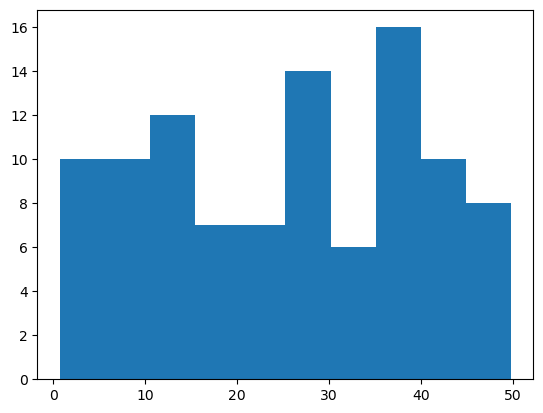

In [6]:
from scipy.stats import uniform
from scipy.stats import norm

a = 0
b = 50

mu0 = 178
tau = 20


prior_sigma = uniform(a,b)

prior_samples_sigma = prior_sigma.rvs(100)

plt.hist(prior_samples_sigma)
plt.plot()



[]

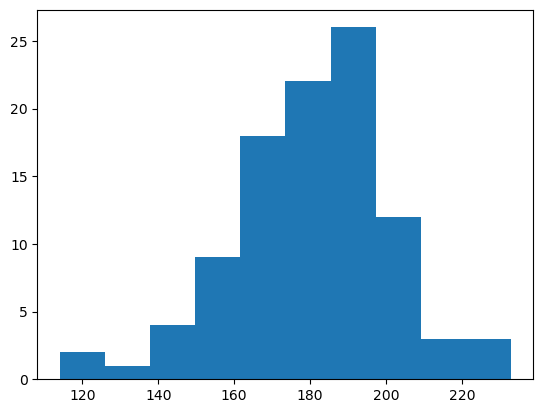

In [7]:

prior_mu = norm(mu0,tau)
prior_samples_mu = prior_mu.rvs(100)
plt.hist(prior_samples_mu)
plt.plot()



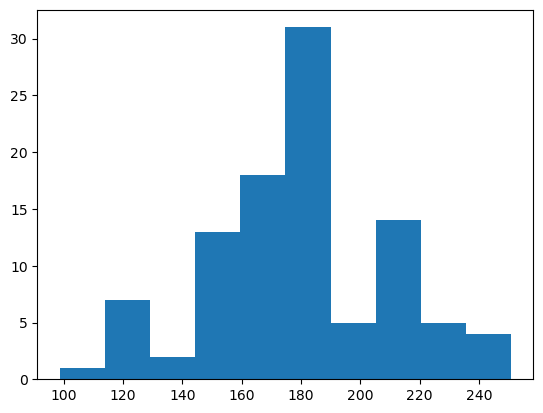

In [8]:
from scipy.stats import uniform
from scipy.stats import norm

sigma = uniform.rvs(0,50, 100)
mu = norm.rvs(178,np.sqrt(400), 100)

height = []
for i in range(100):
    height.append(norm.rvs(mu[i],sigma[i],1))

plt.hist(np.array(height))
plt.show()




We want now to integrate our data in the model, therefore we need to specify our likelihood:

$$p(y|\mu,\sigma^2) = N(y|\mu,\sigma^2).$$


At this point we have several ways of computing the posterior of our model, as we have seen during the last lesson. Unfortunately, the grid method tends to be very inefficient and inaccurate, and is therefore not the right choice in this case, since we start having a large number of observations. Also, we don't want to use the closed form that we derived for the Gaussian model, because we need to perform inference on $\sigma$ as well, and because we don't want to derive again all the maths each time we change the model.

For all these reason, we will use the *Laplace approximation*, as implemented in the toolbox *tools.py$. This function takes the as input the priors and the likelihood of our model, and gives us back an approximation of the posterior under the form of a Gaussian distribution fitting our posterior parameter space. So, the posterior Gaussian will have dimension equal to the number of parameters.

Let's see this machine in action:

In [9]:
# We specify a likelihood N(\mu, \sigma^2)

# initial values for the parameters mu and sigma2
mu = 183.
sigma = 2.

# Initializing the likelihood
likelihood = 'gaussian'
parameters = [mu, sigma]

# Defining the prior with hyperparameters 
prior_mu_mean = 178
prior_mu_sigma = 20
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]


In [10]:
solution = laplace_solution([mu,sigma], [], data1.height, likelihood, [prior_mu, prior_sigma])

C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1227.9161145881924
        x: [ 1.546e+02  7.731e+00]
      nit: 27
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 6.046e-01 -5.875e-01]
            [-5.875e-01  5.738e-01]]
     nfev: 125
     njev: 40


It seems that the machine worked correctly, let's explore in detail what we obtained. 
The solution is composed by the mean and the covariance of the posterior, in our case for the parameters $\mu$ and $\sigma$.
We can therefore sample from the posterior to explore our new model of height:

In [11]:
posterior_mean = solution[0]
posterior_covariance = solution[1]

posterior_samples = multivariate_normal.rvs(posterior_mean, posterior_covariance, size = 1000)


In [13]:
posterior_samples[0]

array([154.37817779,   7.95877082])

[]

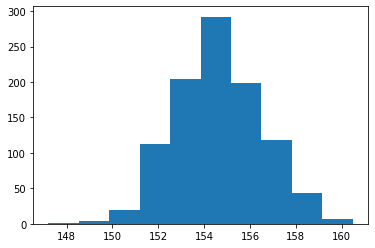

In [187]:
plt.hist(np.array([posterior_samples[i][0] for i in range(1000)]))
plt.plot()

[]

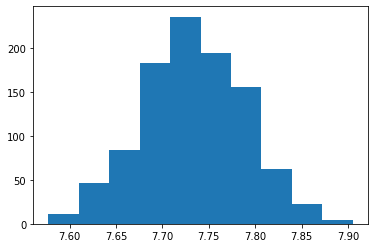

In [188]:
plt.hist(np.array([posterior_samples[i][1] for i in range(1000)]))
plt.plot()

**Exercise.** Compute mean, standard deviation and 85% interval for the posterior parameters.

**Exercise.** Play around with the model, observe how the posterior changes in relation to the prior values.

**Exercise.** Play with priors and initialization to test the model, plot the results and compare them.

**Exercise.** Include the individual with age less than 18 years, and repeat the analysis. 